## Data Cleaning

First import necessary packages for cleaning and anything else that is needed.

In [1]:
import pandas as pd
import numpy as np
import os
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt

pysqldf = lambda q: sqldf(q, globals())
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading data into dataframes

In [2]:
Bommoviegross = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
BomGross = pd.DataFrame(Bommoviegross)

imdbname = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
imdbName = pd.DataFrame(imdbname)

imdbtitlea = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
imdbTitleAkas = pd.DataFrame(imdbtitlea)

imdbtitleb = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
imdbTitleBasic = pd.DataFrame(imdbtitleb)

imdbtitlec = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
imdbTitleCrew = pd.DataFrame(imdbtitlec)

imdbtitlep = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')
imdbTitlePrin = pd.DataFrame(imdbtitlep)

imdbtitler = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
imdbTitleRat = pd.DataFrame(imdbtitler)

rtmov = pd.read_csv('./zippedData/rt.movie_info.tsv.gz', sep='\t')
rtmovie = pd.DataFrame(rtmov)

rtrev = pd.read_csv('./zippedData/rt.reviews.tsv.gz', sep='\t', encoding= 'unicode_escape')
rtreview = pd.DataFrame(rtrev)

tmdb = pd.read_csv('./zippedData/tmdb.movies.csv.gz')
tmdbmov = pd.DataFrame(tmdb)

tnm = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
tnmmov = pd.DataFrame(tnm)

Functions For notebook

In [3]:
def BustinOut(Dataframe, Column, DictionaryOfNames):
    row_count = 0
    
    Names = DictionaryOfNames.values()
    DictionaryOfNames_List = {}
    for name in Names:
        DictionaryOfNames_List[name] = []
    
    for row in Dataframe[Column]:
        for x in row:
            for k,v in DictionaryOfNames_List.items():
                if x == k:
                    v.append(1)
        for k,v in DictionaryOfNames_List.items():
            if len(v) <= row_count:
                v.append(0)
        row_count += 1
    
    for k,v in DictionaryOfNames_List.items():
        Dataframe[k] = v
    
    return Dataframe

Cleaning up Tables

In [4]:
#This table is going to be used for Review/Ratings for directors/writers (IMDB)

#Joining imdb tables to make a master table
q = '''SELECT *
       FROM imdbTitleBasic
       LEFT JOIN imdbTitleRat
       USING (tconst)
       Left JOIN imdbTitleCrew
       USING (tconst)
       ;
    '''
imdbMaster = pysqldf(q)

#cleaning up directors and writers columns, putting in the actual names for imdbMaster table
imdbMaster['directors'] = imdbMaster['directors'].astype(str)
imdbMaster['writers'] = imdbMaster['writers'].astype(str)
imdbMaster['directors'] = imdbMaster['directors'].map(lambda x: x.split(','))
imdbMaster['writers'] = imdbMaster['writers'].map(lambda x: x.split(','))
#
All_names = imdbName.set_index('nconst')['primary_name'].to_dict()
#
DirectorNamesList = []
for entry in imdbMaster['directors']:
    DirectorNamesList.append([All_names.get(item,item) for item in entry])
imdbMaster['Director_Names'] = DirectorNamesList
#
WritersNamesList = []
for entry in imdbMaster['writers']:
    WritersNamesList.append([All_names.get(item,item) for item in entry])
imdbMaster['Writers_Names'] = WritersNamesList

#Some Writers have ['None'] so putting nan values in so when I add up the writers it wont think None is an actual
#Writer
imdbMaster = imdbMaster.applymap(lambda x: np.nan if x == ['None'] else x)

#Making new rows of number of directors and number of writers
imdbMaster['Num_of_Directors'] = imdbMaster['Director_Names'].map(lambda x: len(x) if type(x)==list else 0)
imdbMaster['Num_of_Writers'] = imdbMaster['Writers_Names'].map(lambda x: len(x) if type(x)==list else 0)

#Drop Anything with a missing rating
imdbMaster = imdbMaster.dropna(subset=['averagerating'])

#Fill runtime Nan's with average

In [5]:
#Cleaning up tnmfile
#This table is going to be used for Budget/Gross Comparison and during the season

#Dropping columns with $0 for domestic_gross and worldwide_gross (only 367 out of 5782 data entries: ~5%)
df_to_drop1 = tnmmov.loc[(tnmmov['domestic_gross'] == '$0') & (tnmmov['worldwide_gross'] == '$0')] #throw these out
newtnm = pd.concat([tnmmov,df_to_drop1]).drop_duplicates(keep=False)

#Making production_budget, domestic_gross and worldwide_gross values to int instead of string
newtnm['production_budget'] = newtnm.production_budget.map(lambda x: int(x.replace('$','').replace(',','')))
newtnm['domestic_gross'] = newtnm.domestic_gross.map(lambda x: int(x.replace('$','').replace(',','')))
newtnm['worldwide_gross'] = newtnm.worldwide_gross.map(lambda x: int(x.replace('$','').replace(',','')))

#Making a new column for Profit
newtnm['Profit'] = newtnm['worldwide_gross'] - newtnm['production_budget']
#Making a column for % profit
newtnm['Percent_Profit'] = newtnm['Profit'] / newtnm['production_budget']

#Dec 31 is a placeholder date (only 74 entries, lets throw out instead of looking up each movie date)
#Total thrown out is 7.62% of original data
df_to_drop2 = newtnm[newtnm.release_date.map(lambda x: x.startswith('Dec 31,'))]
newtnmForDateComp = pd.concat([newtnm,df_to_drop2]).drop_duplicates(keep=False)
#Lets make the release month and release year into new columns, will be easier to work with
newtnmForDateComp['Release_Month'] = newtnmForDateComp['release_date'].map(lambda x: x[0:3])
newtnmForDateComp['Release_Year'] = newtnmForDateComp['release_date'].map(lambda x: x[-4:])
#Drop the id and release_date column to make it look nicer
newtnmForDateComp = newtnmForDateComp.drop(columns = ['id','release_date'])

In [6]:
#Cleaning up TMDB File
#This table is going to be used for Genre/Popularity comparison

#First drop the unnamed first column
tmdbmov = tmdbmov.drop(tmdbmov.columns[0], axis = 1)
#Lets drop exact duplicate columns
newtmdb = tmdbmov.drop_duplicates()
#Dropping rows that don't have genre values, because that's what we're interested in for this dataframe
df_to_drop3 = newtmdb[newtmdb.genre_ids == '[]']
newtmdb = pd.concat([newtmdb,df_to_drop3]).drop_duplicates(keep=False)

In [7]:
#Continuing to clean up TMDB File
#Adding a new column that'll have the actual GenreNames in it

newGenreKey = {'28':'Action', '12':'Adventure', '16':'Animation', '35':'Comedy', '80':'Crime', '99':'Documentary',
               '18':'Drama', '10751':'Family', '14':'Fantasy', '36':'History', '27':'Horror', '10402':'Music',
               '9648':'Mystery', '10749':'Romance', '878':'Science Fiction', '10770':'TV Movie', '53':'Thriller',
               '10752':'War', '37':'Western'}
newtmdb['genre_ids'] = newtmdb['genre_ids'].map(lambda x: 
                                                     x.replace('[','').replace(']','').replace(' ','').split(','))
GenreNamesList = []
for entry in newtmdb['genre_ids']:
    GenreNamesList.append([newGenreKey.get(item,item) for item in entry])
newtmdb['Genre_Names'] = GenreNamesList

#Bringing out the Genre_Names column and making each genre a different column
BustinOut(newtmdb, 'Genre_Names', newGenreKey)

#Dropping genre_ids column and id, make it look neater
newtmdb = newtmdb.drop(columns = ['genre_ids', 'id'])

In [8]:
#Box Office Data
BomGross['foreign_gross'] = BomGross['foreign_gross'].str.replace(',','').astype(float)
BoxOfficeInfo= BomGross.groupby(['year'],as_index=False).mean()
BoxOfficeInfo


,year,domestic_gross,foreign_gross
0,2010,3.144559e+07,4.577789e+07
1,2011,2.535052e+07,5.348459e+07
2,2012,2.767584e+07,6.815155e+07
3,2013,3.128212e+07,8.103607e+07
4,2014,2.643923e+07,7.131079e+07
5,2015,2.461338e+07,7.960187e+07
6,2016,2.598996e+07,9.804637e+07
7,2017,3.416646e+07,1.126457e+08
8,2018,3.601042e+07,1.010086e+08


# Ploting the Data

First Question: What Genre is the most popular? (Using newtmdb file)

Text(198.125, 0.5, 'Average Rating')

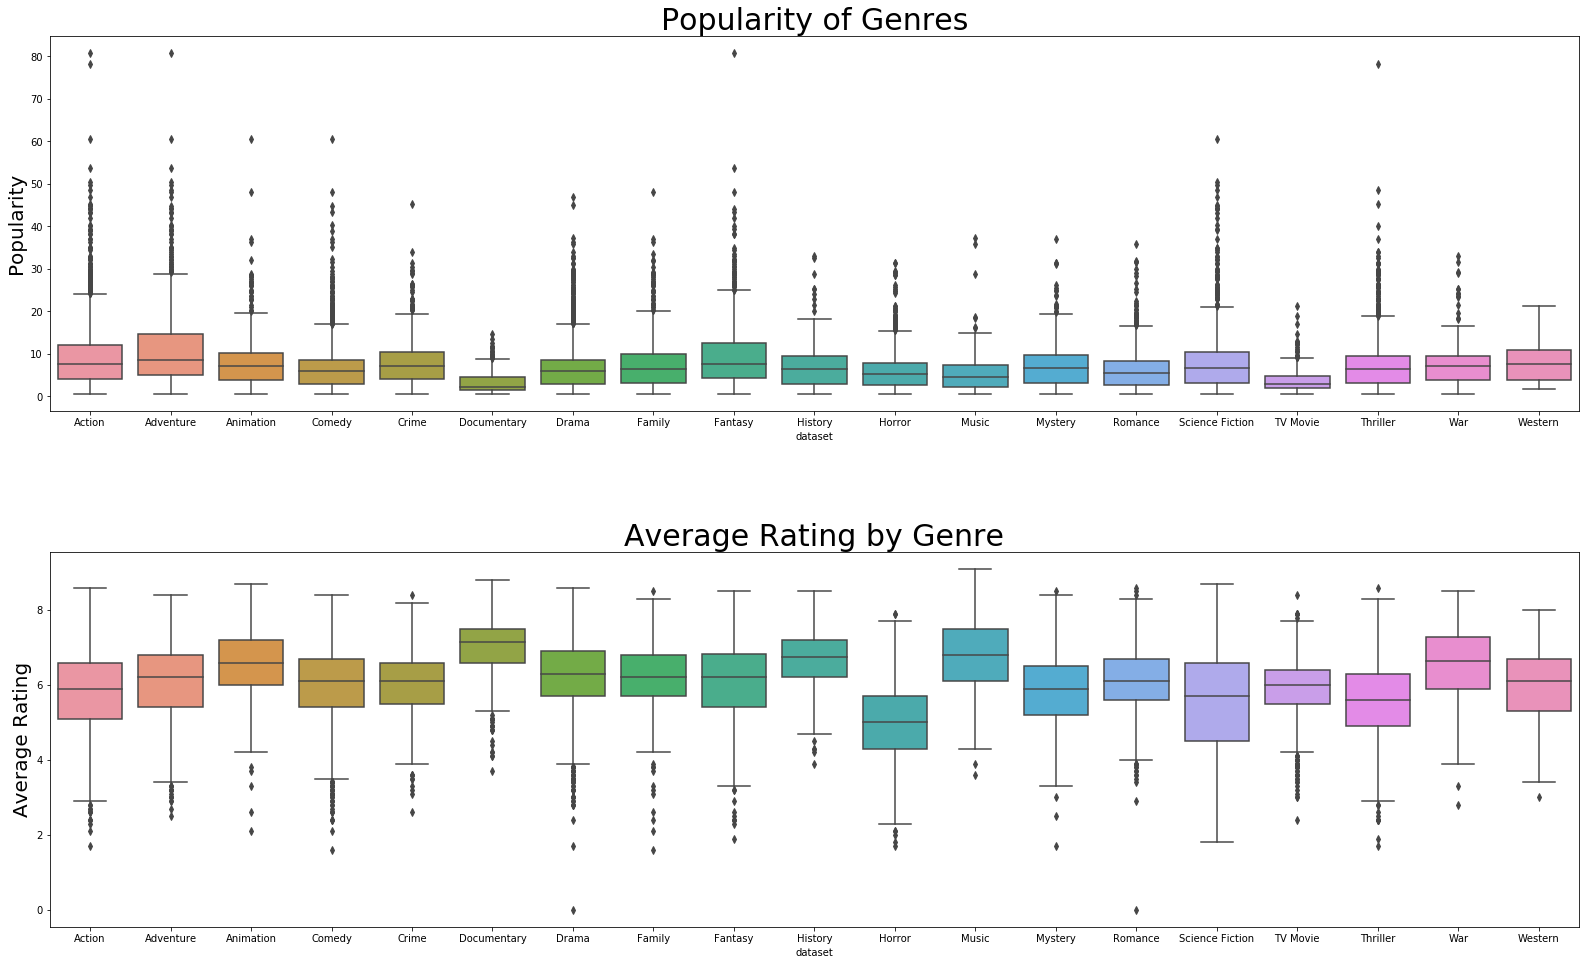

In [9]:
#Getting rid of anything under vote_count of 10
newtmdb.drop(newtmdb[newtmdb['vote_count'] < 11].index, inplace=True)

#Getting the list of genres
ListOfGenres = list(newGenreKey.values())
#Creating a dictionary of all the different genre tables
GenrePopTables = {}
for genre in ListOfGenres:
    GenrePopTables[genre] = newtmdb[newtmdb[genre]==1]
#Putting all the genre tables together to plot
concatenated = pd.concat([GenrePopTables[genre].assign(dataset = genre) for genre in ListOfGenres])


fig1, (ax1,ax2) = plt.subplots(2,1,figsize = (25,16))
fig1.tight_layout(pad = 12.0)

sns.boxplot(x='dataset',y='popularity',data=concatenated, ax = ax1)
sns.boxplot(x='dataset',y='vote_average',data=concatenated, ax = ax2)


ax1.set_title('Popularity of Genres', fontsize = 30)
ax2.set_title('Average Rating by Genre', fontsize = 30)
ax1.set_ylabel('Popularity', fontsize = 20)
ax2.set_ylabel('Average Rating', fontsize = 20)
#Maybe throw out counts with a low vote count, maybe less than 10? maybe more?

Second Question: Is there a time of year movies earn the most profit? (Using newtnmForDateComp file)

Text(198.125, 0.5, 'Average Percent Profit')

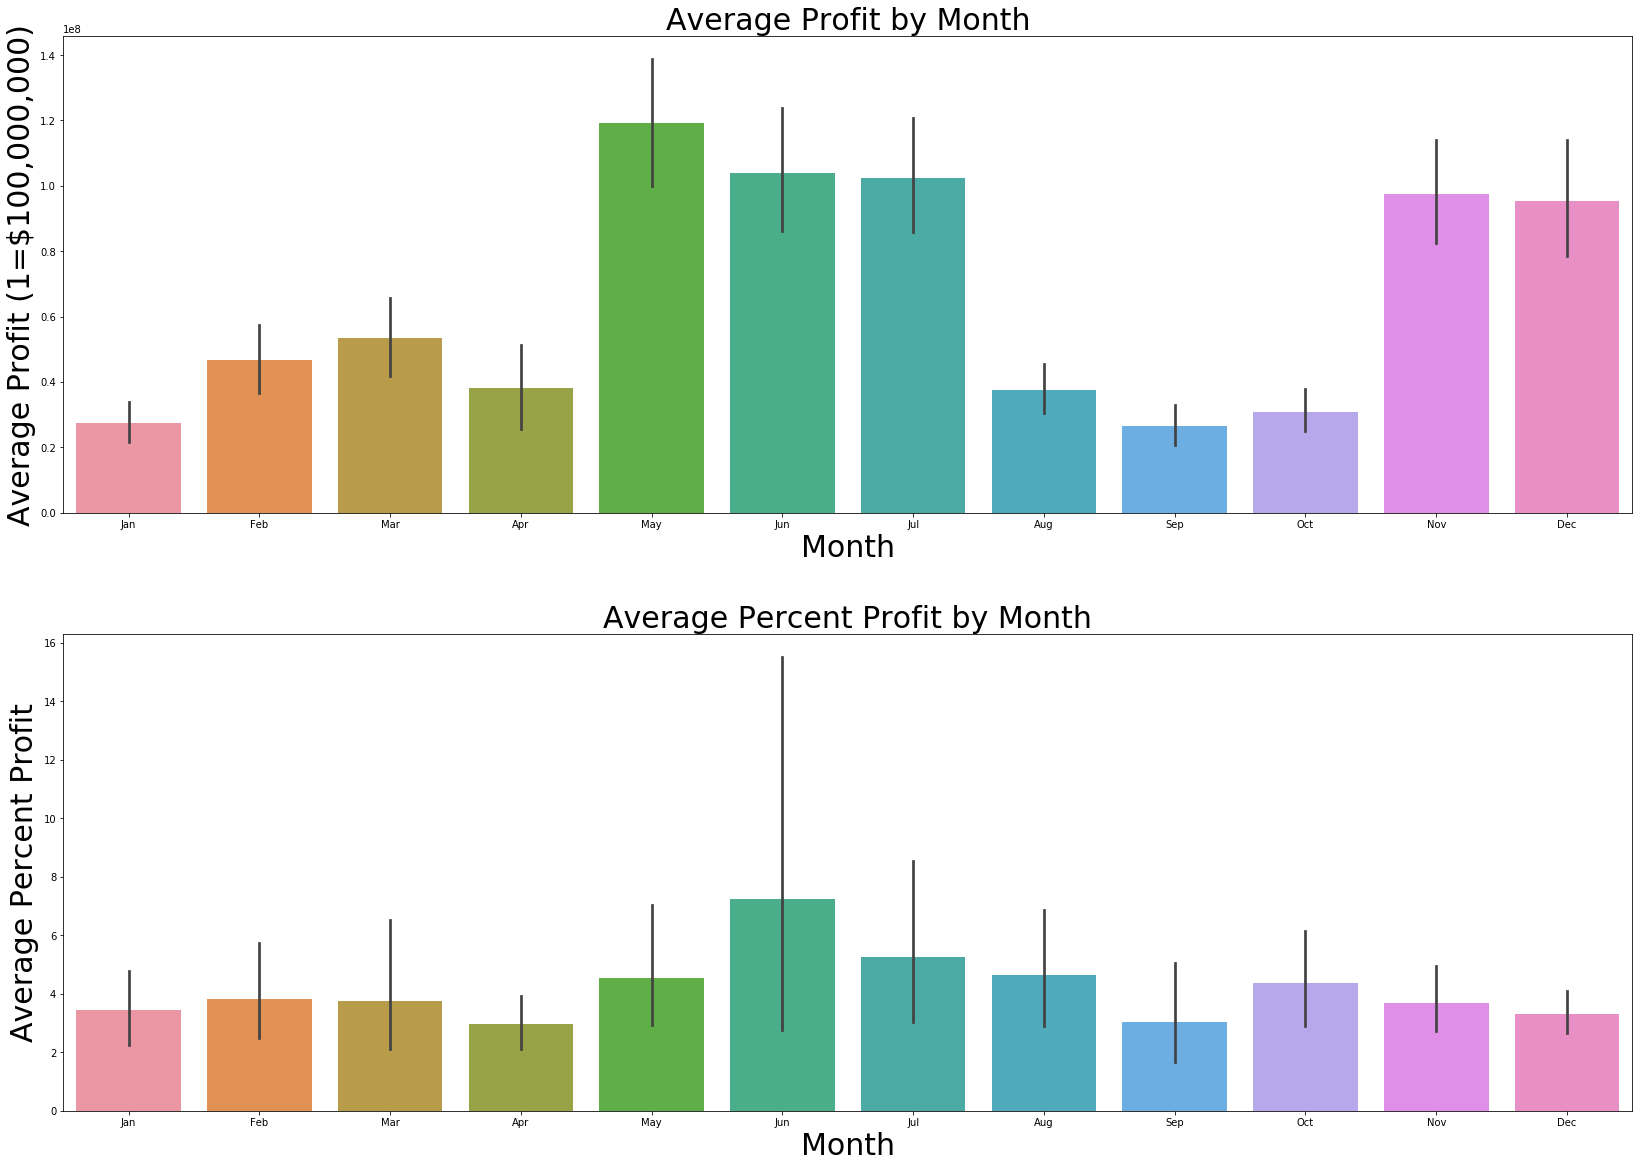

In [10]:
fig2, (ax3,ax4) = plt.subplots(2,1,figsize = (25,18))
fig2.tight_layout(pad = 10.0)

ax3.set_title('Average Profit by Month', fontsize = 30)
ax4.set_title('Average Percent Profit by Month',fontsize = 30)

sns.barplot(x='Release_Month', y='Profit',data=newtnmForDateComp, ax=ax3,
           order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
sns.barplot(x='Release_Month', y='Percent_Profit',data=newtnmForDateComp, ax=ax4,
           order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

ax3.set_xlabel('Month',fontsize=30)
ax3.set_ylabel('Average Profit (1=$100,000,000)',fontsize=30)
ax4.set_xlabel('Month',fontsize=30)
ax4.set_ylabel('Average Percent Profit',fontsize=30)

Third Question: Should there be a cap on budget or a minimum? (using newtnm File)

3230590.9203397357

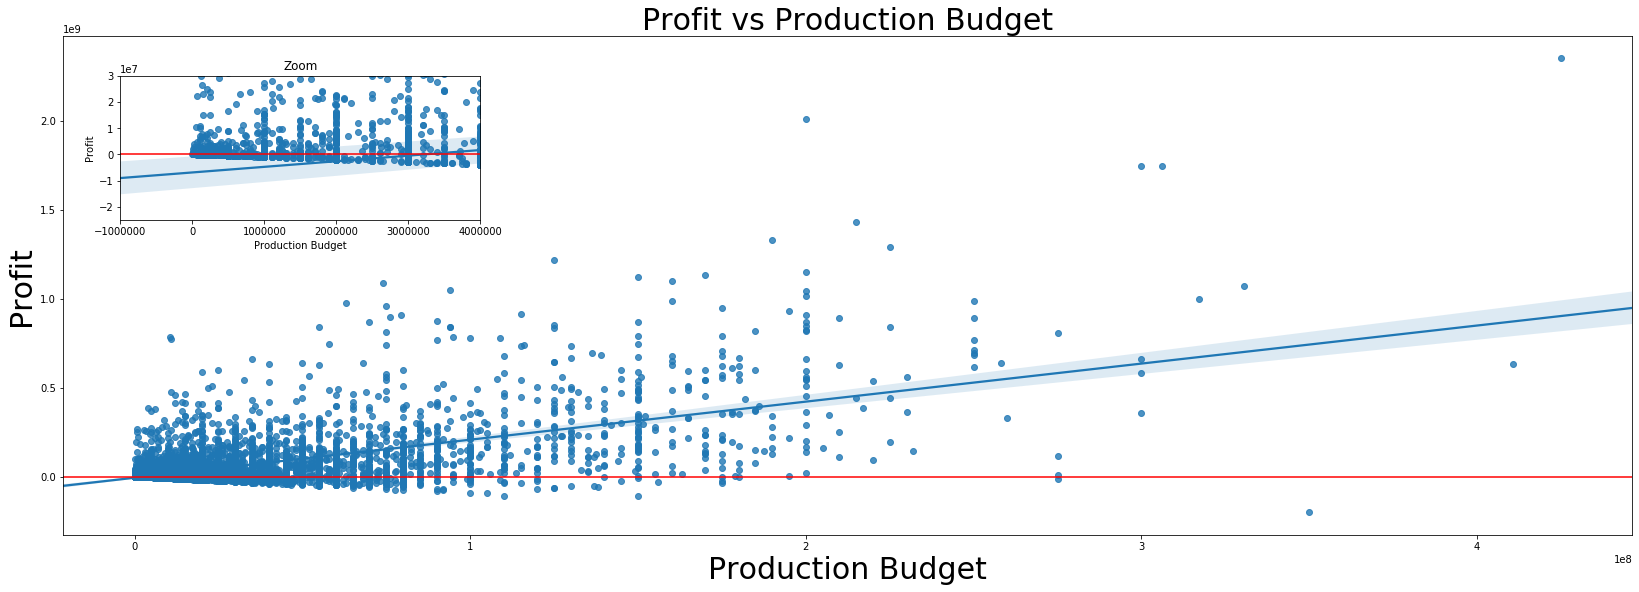

In [11]:
fig3, ax5 = plt.subplots(figsize=(25,10))
fig3.tight_layout(pad = 10.0)

p=sns.regplot(x='production_budget',y='Profit',data=newtnm,ax=ax5)

ax5.set_title('Profit vs Production Budget', fontsize = 30)
ax5.set_xlabel('Production Budget',fontsize=30)
ax5.set_ylabel('Profit',fontsize=30)
ax5.axhline(0,color='red')

ax6 = plt.axes([0.1, 0.6, 0.2, 0.2])
sns.regplot(x='production_budget',y='Profit',data=newtnm,ax=ax6)
ax6.set_title('Zoom')
ax6.set_xlim([-1000000,4000000])
ax6.set_ylim([-25000000,30000000])
ax6.set_xlabel('Production Budget')
ax6.set_ylabel('Profit')
ax6.axhline(0,color='red')

xline=p.get_lines()[0].get_xdata()
yline=p.get_lines()[0].get_ydata()
xline=list(xline)
yline=list(yline)

m=(yline[1]-yline[0])/(xline[1]-xline[0])
b= yline[0]-m*xline[0]
basebudget = (-1*b)/m
basebudget

Fourth Question: Is there specific Dirctors/Writers we want to hire?

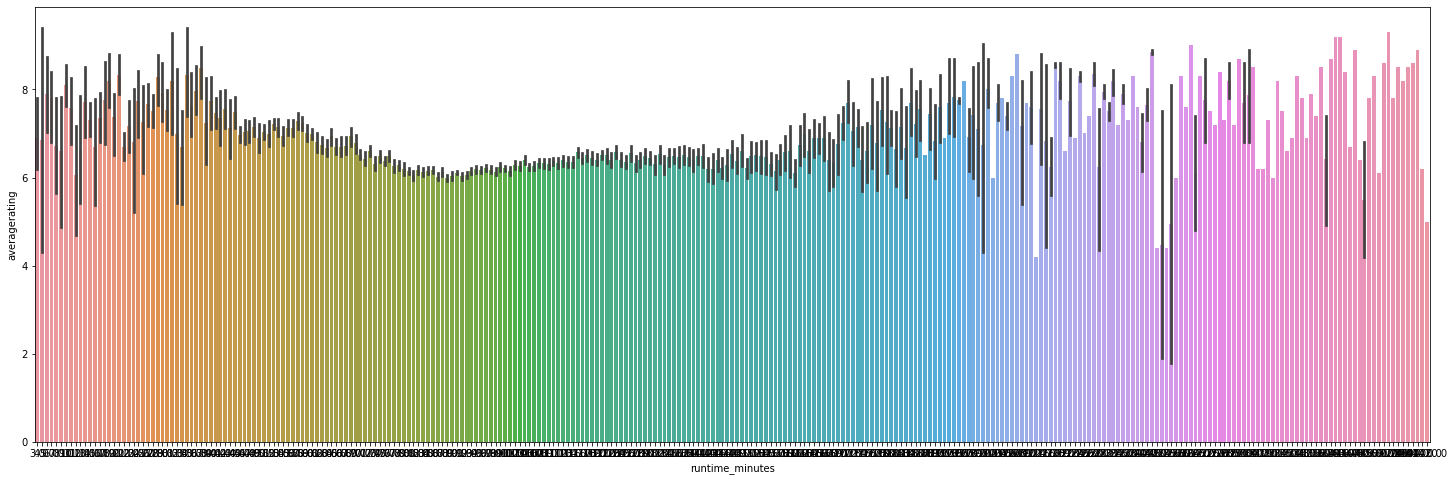

In [12]:
#There is entries with no directors and no writers
#Get rid of nans
# testplot = []
# plotdirector = []
# plotratings = []
# plotiterator = 0
# for row in imdbMaster['Director_Names']:
#     for name in row:
#         plotdirector.append(name)
#         plotratings.append(imdbMaster['averagerating'][plotiterator])
#     plotiterator += 1
    
fig5, ax5 = plt.subplots(figsize=(25,8))
sns.barplot(x='runtime_minutes',y='averagerating',data=imdbMaster,ax=ax5)

In [13]:
test=imdbMaster[imdbMaster.Num_of_Directors==0]
test.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,directors,writers,Director_Names,Writers_Names,Num_of_Directors,Num_of_Writers
34,tt0297400,Snowblind,Snowblind,2015,NaN,"Crime,Drama",6.7,77.0,NaN,NaN,NaN,NaN,0,0
880,tt10050766,Brené Brown: The Call to Courage,Brené Brown: The Call to Courage,2019,76.0,"Documentary,Drama",7.6,445.0,NaN,NaN,NaN,NaN,0,0
1376,tt10112466,Peppa Pig: Festival of Fun,Peppa Pig: Festival of Fun,2019,68.0,"Animation,Family",4.7,73.0,NaN,NaN,NaN,NaN,0,0
1385,tt10115436,Korea: The Never-Ending War,Korea: The Never-Ending War,2019,120.0,Documentary,8.3,31.0,NaN,NaN,NaN,NaN,0,0
1758,tt10163286,Benden Hikâyesi,Benden Hikâyesi,2019,80.0,"Biography,Drama",7.7,6.0,NaN,NaN,NaN,NaN,0,0


Fifth Question: Are some genres more popular during certain times of the year?

In [14]:
BoxOfficeInfo

,year,domestic_gross,foreign_gross
0,2010,3.144559e+07,4.577789e+07
1,2011,2.535052e+07,5.348459e+07
2,2012,2.767584e+07,6.815155e+07
3,2013,3.128212e+07,8.103607e+07
4,2014,2.643923e+07,7.131079e+07
5,2015,2.461338e+07,7.960187e+07
6,2016,2.598996e+07,9.804637e+07
7,2017,3.416646e+07,1.126457e+08
8,2018,3.601042e+07,1.010086e+08


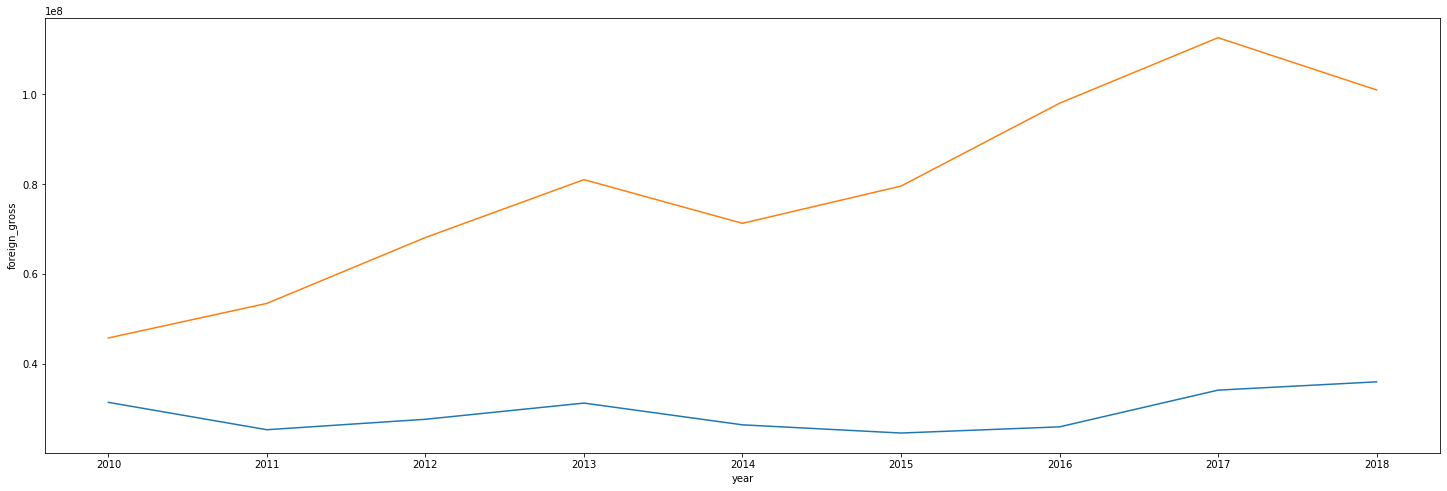

In [15]:
fig55, ax55 = plt.subplots(figsize=(25,8))
sns.lineplot(x='year',y='domestic_gross',data=BoxOfficeInfo,ax=ax55)
sns.lineplot(x='year',y='foreign_gross',data=BoxOfficeInfo)